# Verifying script

In [1]:
import pandas as pd
PATH = "../code/org_website_data.csv"

In [2]:
df = pd.read_csv(PATH, low_memory=False)

In [3]:
df['date'] = pd.to_datetime(df['date']).dt.date
df.groupby('date')['org'].count()

date
2021-11-15    30708
2021-11-16    21199
Name: org, dtype: int64

In [11]:
# send date corrected file to s3
# save_dataframe_to_file("qgiv-stats-data", "org_website.csv", df)
# get_dataframe_from_file("qgiv-stats-data", "org_website.csv")

date
2020-01-15    28053
2020-01-16     8226
Name: org, dtype: int64

In [4]:
targets = ['qgiv', 'mobilecause', 'blackbaud', 'giveeffect', 'donordrive', 'paypal',
           'engagingnetworks', 'networkforgood', 'givelively', 'classy', 'onecause']
targets_cols = {}
for target in targets:
    for column in df.columns:
        if target in column:
            if target not in targets_cols:
                targets_cols[target] = [column]
            else:
                targets_cols[target].append(column)
                
for target in targets:
    df["{}_sum".format(target)] = df[targets_cols[target]].sum(axis=1)

In [ ]:
ref_df = None
for org in df['org'].unique().tolist():
    this_org_data = df[df['org']==org]
    org_groupby = this_org_data.groupby('date')
    
    org_grpd = org_groupby[["{}_sum".format(t) for t in targets]].sum()
    org_grpd['page_count'] = org_groupby['url'].count()
    org_grpd['org'] = org
    org_grpd['url'] = this_org_data['url'].iloc[0]
    
    org_grpd.sort_values('date', ascending=True)
    for t in targets:
        org_grpd["{}_diff".format(t)] = org_grpd["{}_sum".format(t)].diff() / org_grpd['page_count']
    
    if ref_df is None:
        ref_df = org_grpd
    else:
        ref_df = ref_df.append(org_grpd)

In [32]:
# reduce to diffs & dropna (the first row per org will be NA)
ref_df = ref_df.reset_index()
ref_df = ref_df[['date', 'org', 'url'] + [c for c in ref_df.columns if 'diff' in c]].dropna()

In [36]:
q_msk = ref_df['qgiv_diff']<0
c_msk = (ref_df['blackbaud_diff']>0)|(ref_df['giveeffect_diff']>0)|(ref_df['donordrive_diff']>0)|(ref_df['paypal_diff']>0)|(ref_df['engagingnetworks_diff']>0)|(ref_df['networkforgood_diff']>0)|(ref_df['givelively_diff']>0)|(ref_df['classy_diff']>0)|(ref_df['onecause_diff']>0)
len(ref_df[(q_msk)&(c_msk)])

3

In [37]:
ref_df[(q_msk)&(c_msk)]

,date,org,url,qgiv_diff,mobilecause_diff,blackbaud_diff,giveeffect_diff,donordrive_diff,paypal_diff,engagingnetworks_diff,networkforgood_diff,givelively_diff,classy_diff,onecause_diff
5203,2020-02-16,443490,http://www.pawnee.org/,-4.666667,0.0,0.000000,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0
5320,2020-02-16,443598,http://undalumni.org,-0.021978,0.0,0.021978,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
6096,2020-02-16,444373,https://www.ivyprepacademy.org/,-0.086957,0.0,0.000000,0.0,0.0,1.304348,0.0,0.0,0.0,0.0,0.0


# Link or script value change by date

# Exploring

In [23]:
df[['calls_to_action', 'image_count', 'internal_links', 'outbound_links', 'word_count']].mean()

calls_to_action        3.625364
image_count           12.506361
internal_links        70.209818
outbound_links        16.431265
word_count         87284.699451
dtype: float64

## Calls to action

In [10]:
df['calls_to_action'] = df['calls_to_action'].apply(int)

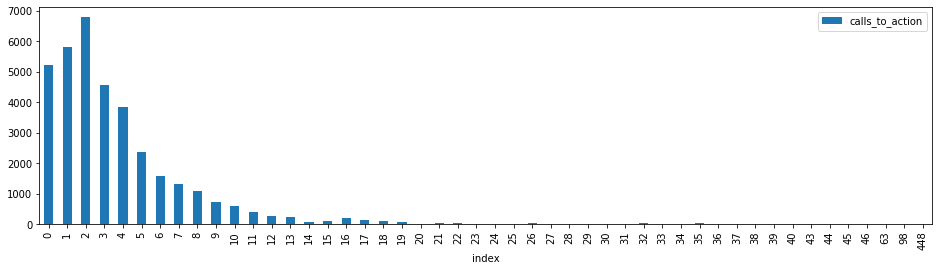

In [11]:
df['calls_to_action'].value_counts().reset_index().sort_values('index').plot(kind='bar', x='index', figsize=(16,4))

## Internal links vs outbound links

In [64]:
df['internal_links'] = df['internal_links'].apply(int)
df['outbound_links'] = df['outbound_links'].apply(int)

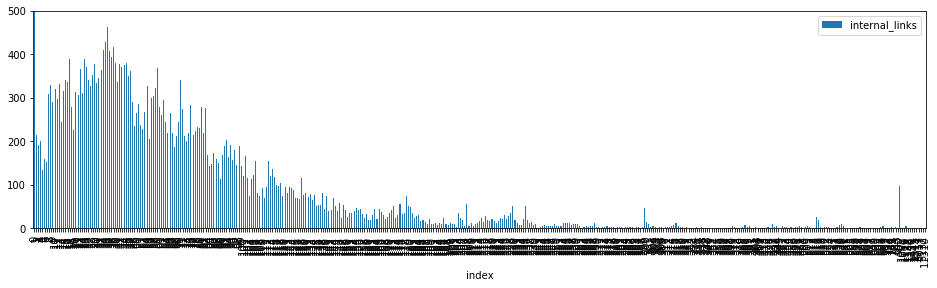

In [85]:
internal_links_values = df['internal_links'].value_counts().reset_index()
internal_links_values.sort_values('index').plot(kind='bar', x='index', ylim=(0,500), figsize=(16,4))

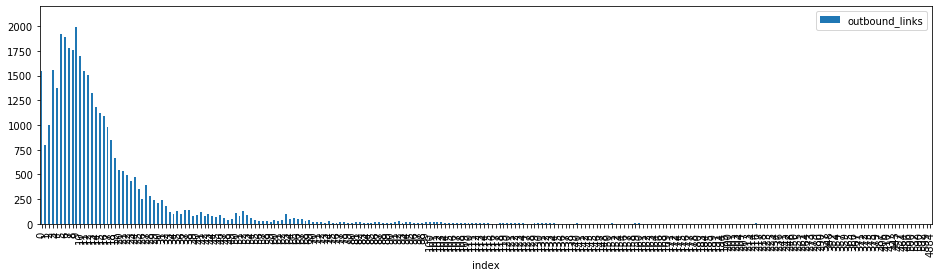

In [77]:
df['outbound_links'].value_counts().reset_index().sort_values('index').plot(kind='bar', x='index', ylim=(0,2200), figsize=(16,4))

In [99]:
df['int / out links'] = df['internal_links'] / df['outbound_links']
df['int / out links'] = df['int / out links'].fillna(0.).round(decimals=0)

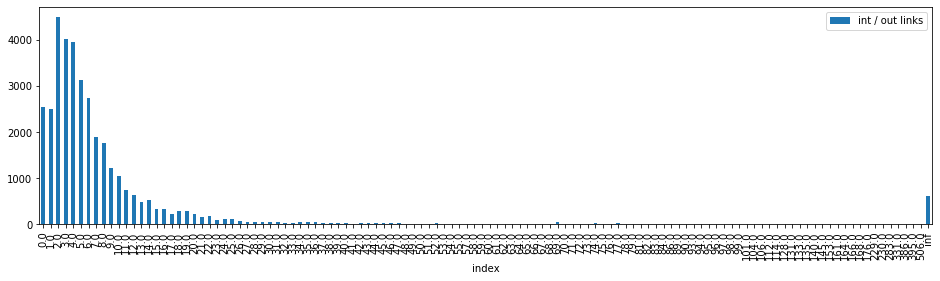

In [104]:
df['int / out links'].value_counts().reset_index().sort_values('index').plot(kind='bar', x='index', figsize=(16,4))

# Calls to action vs 12 month performance 

In [3]:
# load transactions
trans = get_dataframe_from_file("trans-records", "transactions.csv")
# load website data
sitedata = get_dataframe_from_file("qgiv-stats-data", "org_website.csv")

In [7]:
trans = trans[trans['year']==2019]

,amount,amount_std,creatingTransactionFor,date,day,donations_amt,donations_count,email,events_amt,events_count,...,recurring_creatingTransaction,registrations_amt,registrations_count,source,state,status,transDonationEntity,transDonationEntityType,year,zip


In [12]:
len_all = len(trans)
trans = trans[(trans['status']=='A')&(trans['source']=='don_form')]
len_a = len(trans)
len_all, len_a

(11430, 6988)

In [13]:
trans_agg = trans[['org', 'amount']].groupby('org')['amount'].sum().reset_index()

In [14]:
trans_agg.head()

,org,amount
0,6,180.0
1,13,10.0
2,31,100.0
3,41,725.0
4,42,783.0


In [18]:
trans_agg['calls_to_action'] = 0
trans_agg['calls_to_action'] = trans_agg['org'].apply(lambda x: sitedata[sitedata['org']==x]['calls_to_action'].mean())

In [19]:
trans_agg[['amount', 'calls_to_action']].mean()

amount             956.133326
calls_to_action      3.303438
dtype: float64

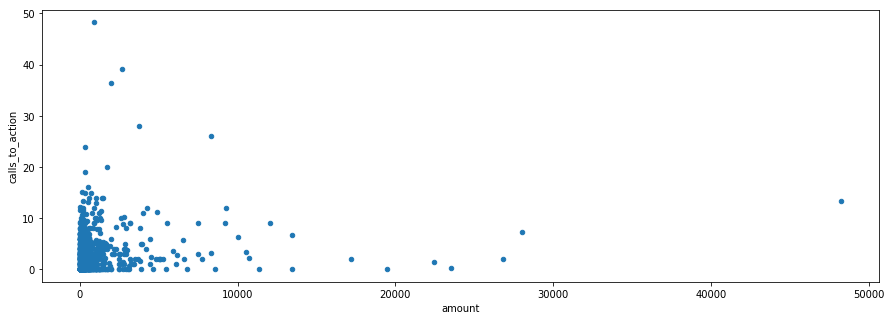

In [21]:
trans_agg[['amount', 'calls_to_action']].plot(kind='scatter', x='amount', y='calls_to_action', figsize=(15,5))

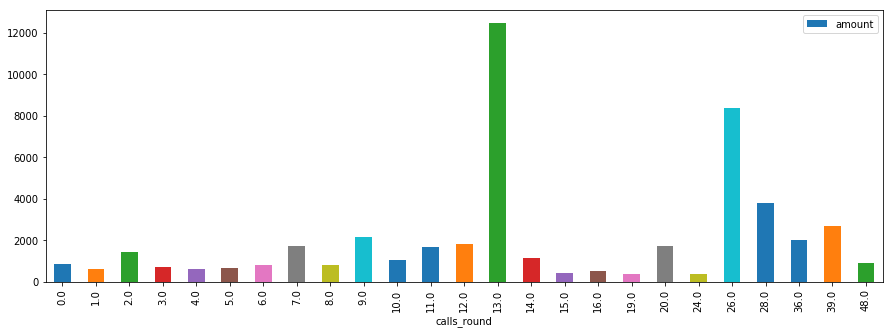

In [31]:
trans_agg['calls_round'] = trans_agg['calls_to_action'].round(decimals=0)

trans_agg.groupby('calls_round')['amount'].mean().reset_index().plot(kind="bar", x='calls_round', y='amount', figsize=(15,5))

# Qgiv page presence to performance

In [ ]:
# load transactions
trans = get_dataframe_from_file("trans-records", "transactions.csv")
# load website data
sitedata = get_dataframe_from_file("qgiv-stats-data", "org_website.csv")

In [ ]:
trans = trans[trans['year']==2019]
trans = trans[(trans['status']=='A')&(trans['source']=='don_form')]

In [ ]:
trans_agg = trans[['org', 'amount']].groupby('org')['amount'].sum().reset_index()

In [48]:
org_qgiv_agg = sitedata.groupby('org')[[c for c in sitedata.columns if 'qgiv' in c]].sum().reset_index()
org_qgiv_agg = org_qgiv_agg.merge(sitedata.groupby('org')['url'].count().reset_index(), on='org')
org_qgiv_agg['presence'] = (org_qgiv_agg['iframe_source_qgiv'] + org_qgiv_agg['link_target_qgiv'] + org_qgiv_agg['script_source_qgiv']) / org_qgiv_agg['url']
org_qgiv_agg = org_qgiv_agg.merge(trans_agg, on='org')[['org', 'presence', 'amount']]

In [54]:
org_qgiv_agg['presence_round'] = org_qgiv_agg['presence'].round(decimals=1)
org_qgiv_agg.head()

,org,presence,amount,presence_round
0,6,3.0,180.0,3.0
1,13,2.0,10.0,2.0
2,31,0.0,100.0,0.0
3,41,1.0,725.0,1.0
4,42,0.0,783.0,0.0


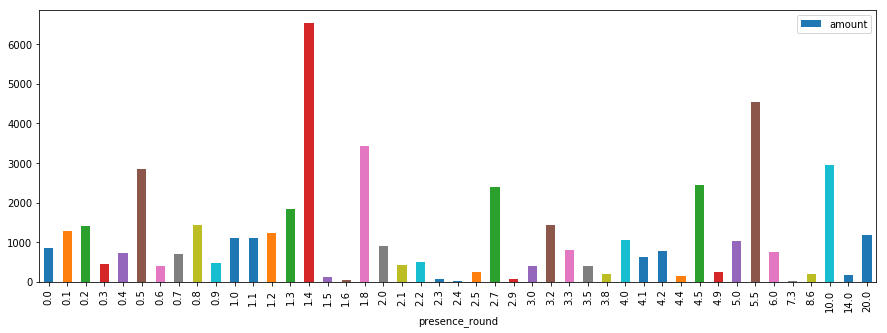

In [55]:
org_qgiv_agg.groupby('presence_round')['amount'].mean().reset_index().plot(kind='bar', x='presence_round', y='amount', figsize=(15,5))